In [45]:
import pandas as pd
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [46]:
df = pd.read_csv('combined_dataset.csv')
df.rename(columns={df.columns[0]: 'Local Date'}, inplace=True)
df_new = df.drop(columns=['Local Date'])

correlation_with_target = df_new.corr()['NASDAQ_Volatility'].abs()
threshold = 0.15 # You can adjust this threshold according to your needs
# Find columns that do not meet the threshold
columns_to_drop = correlation_with_target[correlation_with_target < threshold].index
df_dropped = df.drop(columns=columns_to_drop)

# Assuming the dataset spans a considerable time range, we can pick a cut-off date
# For example, if we want to use the last 20% of dates for testing, we can do the following:
cut_off_index = int(len(df) * 0.8)
cut_off_date = df.iloc[cut_off_index]['Local Date']

# Splitting the data based on the cut-off date
train_df = df_dropped[df_dropped['Local Date'] < cut_off_date]
test_df = df_dropped[df_dropped['Local Date'] >= cut_off_date]

# Preparing the feature (X) and target (y) variables
X_train = df.drop(columns=['NASDAQ_Volatility', 'Local Date']).values
y_train = df['NASDAQ_Volatility'].values
X_test = df.drop(columns=['NASDAQ_Volatility', 'Local Date']).values
y_test = df['NASDAQ_Volatility'].values


In [47]:
param_grid = {
    'learning_rate': [0.01],
    'n_estimators': [150],
    'max_depth': [3],
    'gamma': [0],
}

In [48]:
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)

In [49]:
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')

# Perform grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and best negative mean squared error
print("Best Parameters:", grid_search.best_params_)
best_r2 = grid_search.best_score_
print("Best R-squared:", best_r2)

# Use the best estimator to make predictions
best_regressor = grid_search.best_estimator_
y_pred = best_regressor.predict(X_test)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150; total time=   0.6s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150; total time=   0.7s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150; total time=   0.7s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150; total time=   0.6s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=150; total time=   0.7s
Best Parameters: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150}
Best R-squared: -0.26480854162868334


In [50]:
r_squared = r2_score(y_test, y_pred)
print(f'R-squared on Test Set: {r_squared}')
mse = mean_squared_error(y_test, y_pred)
print(f'MSE on Test Set: {mse}')

R-squared on Test Set: 0.6165718951006884
MSE on Test Set: 3.5245599028595255e-08


R-squared on Test Set: 0.6165718951006884
MSE on Test Set: 3.5245599028595255e-08


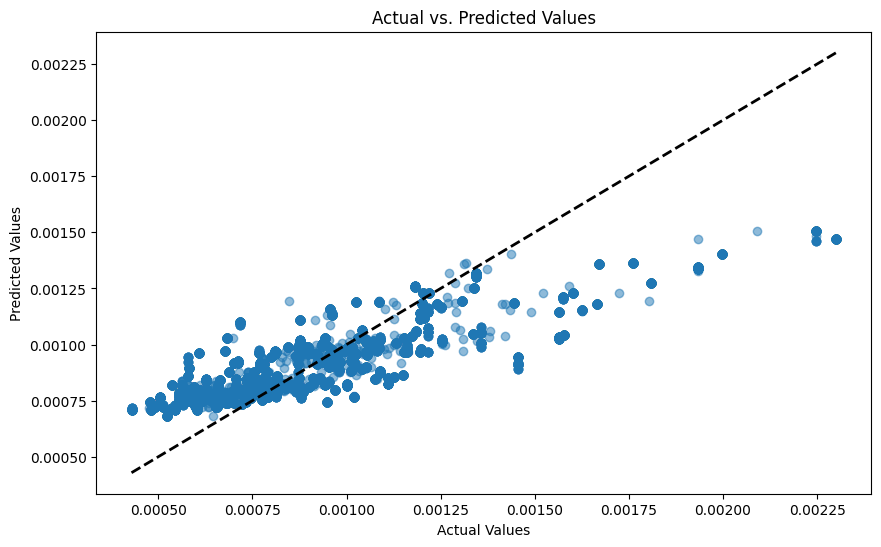

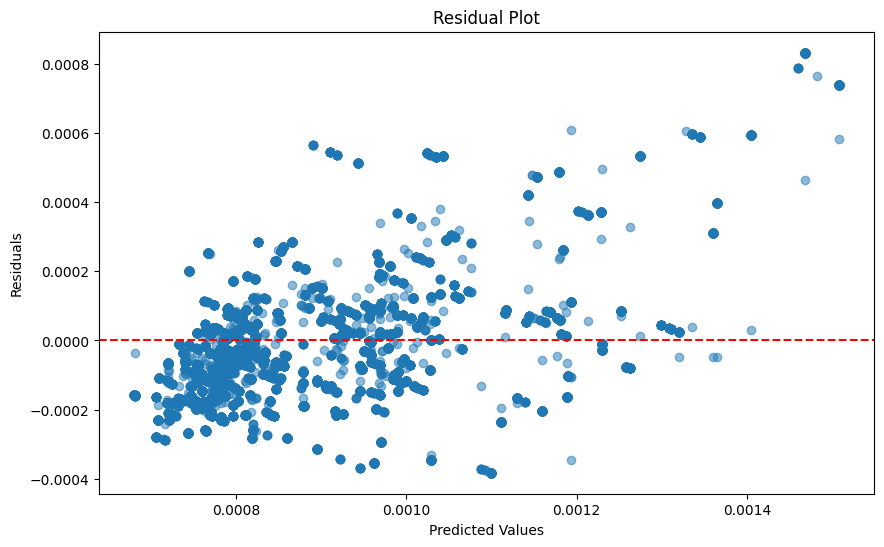

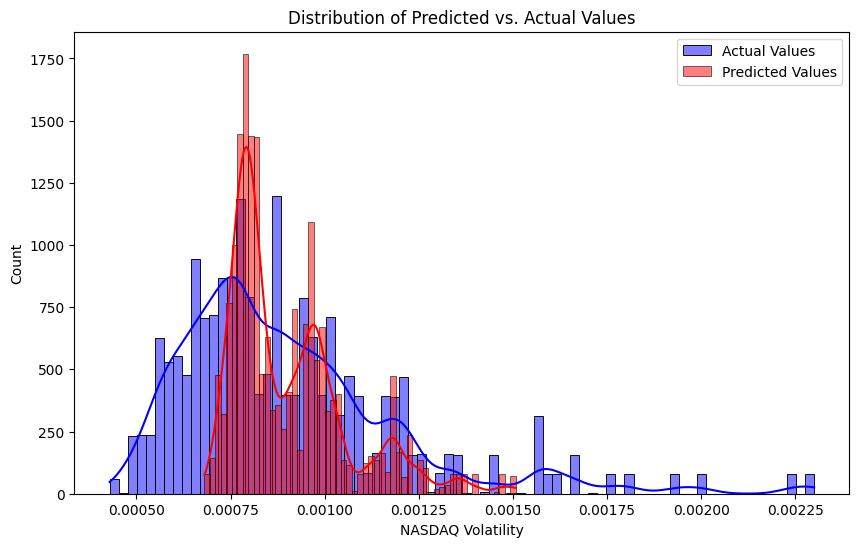

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error

# Make predictions with the best estimator
y_pred = best_regressor.predict(X_test)

# Calculate R-squared and Mean Squared Error
r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'R-squared on Test Set: {r_squared}')
print(f'MSE on Test Set: {mse}')

# Actual vs. Predicted Values Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Distribution of Predicted vs. Actual Values
plt.figure(figsize=(10, 6))
sns.histplot(y_test, color="blue", label="Actual Values", kde=True)
sns.histplot(y_pred, color="red", label="Predicted Values", kde=True)
plt.title('Distribution of Predicted vs. Actual Values')
plt.xlabel('NASDAQ Volatility')
plt.legend()
plt.show()
